Tutorial on YouTube Chanel:
Text Visualization | Lecture 2 | CPE 393 Text Analytics
https://www.youtube.com/watch?v=rAQCQKnkNh0&t=774s

##### <b>Load Dataset</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
df = pd.read_csv('un-general-debates.csv')
df.sample(5)

,session,year,country,text
1052,41,1986,HUN,I should like first to join preceding speakers...
1500,51,1996,GRD,﻿Virtue constitutes the greatest\nform of huma...
3884,42,1987,GMB,"﻿\nAllow me, first of all, to extend to you. S..."
5465,70,2015,WSM,Last Friday ushered in a new era in our search...
4741,35,1980,ETH,"﻿I should like, on behalf of the Ethiopian del..."


In [3]:
df.count()

session    7507
year       7507
country    7507
text       7507
dtype: int64

In [4]:
# Primary key

df[['session', 'country']].drop_duplicates().count()

session    7507
country    7507
dtype: int64

##### <b>DataFrame Summary Statistics</b>

In [5]:
df['length'] = df['text'].str.len()

In [6]:
df.columns

Index(['session', 'year', 'country', 'text', 'length'], dtype='object')

In [7]:
df.dtypes

session     int64
year        int64
country    object
text       object
length      int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
 4   length   7507 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 293.4+ KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [10]:
df[['country']].describe(include='O').T

,count,unique,top,freq
country,7507,199,IRN,46


##### <b>Check Missing Data</b>

In [11]:
df.isna().sum()

session    0
year       0
country    0
text       0
length     0
dtype: int64

##### <b>Plotting distribution</b>

<AxesSubplot:>

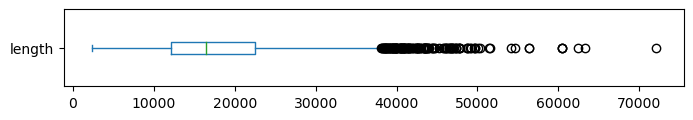

In [12]:
df['length'].plot(kind='box', vert=False, figsize=(8,1))

<AxesSubplot:ylabel='Frequency'>

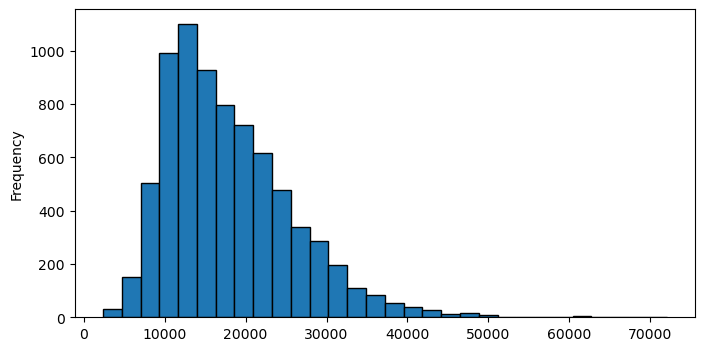

In [13]:
df['length'].plot(kind='hist', bins=30, figsize=(8,4), edgecolor='k')

##### <b>Distribution across categories</b>

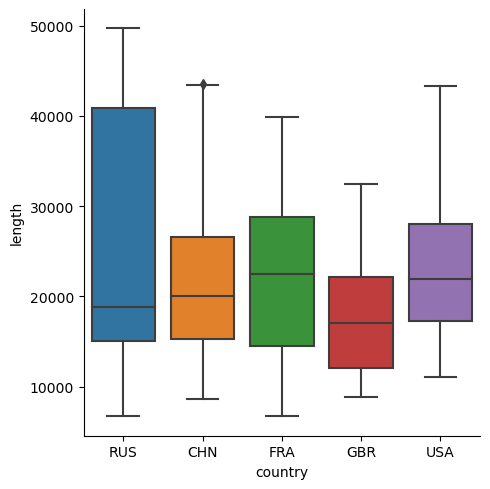

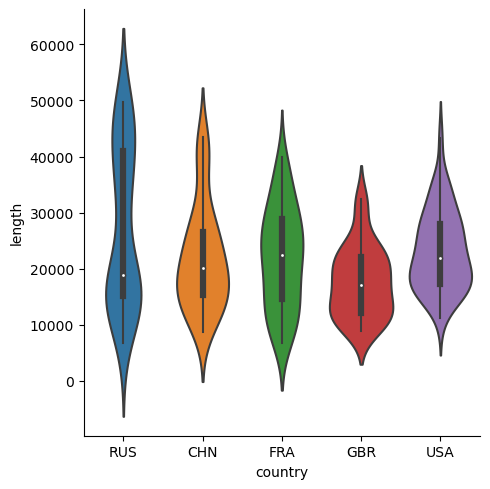

In [14]:
import seaborn as sns

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

##### <b>Developement over time Number of countries</b>

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

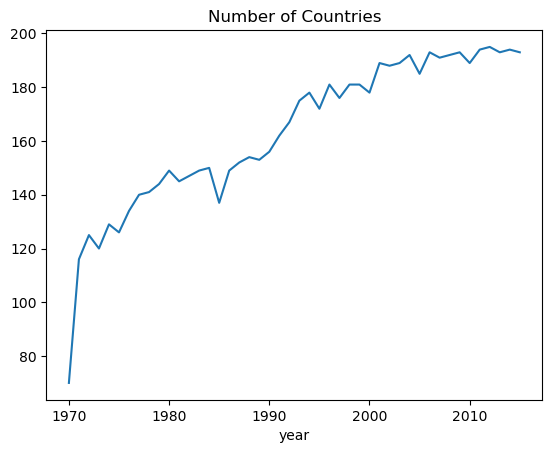

In [15]:
df.groupby('year').size().plot(title='Number of Countries')

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

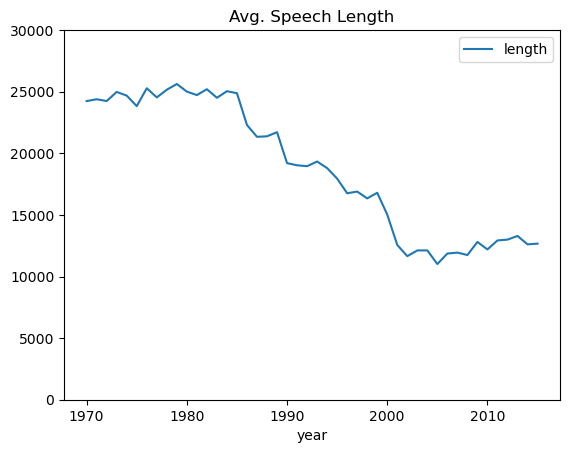

In [16]:
df.groupby('year').agg({'length':'mean'}).plot(title='Avg. Speech Length', ylim=(0,30000))

##### <b>Simple Text Processing</b>

In [17]:
# Case Folding
str.lower('Hello World')

'hello world'

In [18]:
# Tokenization

import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [19]:
text = "Let's defeat SARS-Coc-2 together in 2021!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-Coc-2|together|in


In [20]:
# Stop word removal
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samapant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [21]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [22]:
remove_stop(tokens)

['Let', 'defeat', 'SARS-Coc-2', 'together']

In [23]:
# Processing a pipeline

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
prepare(text, pipeline)

['let', 'defeat', 'sars-coc-2', 'together']

In [25]:
# Apply pipeline

# Series: map
# Series: map
# DaraFrame: applymap
# DataFrame: applymap

df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df.sample(10)

,session,year,country,text,length,tokens
2902,64,2009,EGY,"\nMr. President, on behalf of the African cont...",17342,"[mr, president, behalf, african, continent, al..."
3852,42,1987,COG,"﻿\nThe choice of you, Sir, at the beginning of...",19546,"[choice, sir, beginning, session, assume, impo..."
4877,69,2014,QAT,"At the outset, \nI would like to congratulate ...",13602,"[outset, would, like, congratulate, excellency..."
994,41,1986,BHS,On behalf of the Government and people of a fe...,22342,"[behalf, government, people, fellow, commonwea..."
5055,66,2011,AUT,This year has once \nagain confirmed the impor...,9942,"[year, confirmed, importance, united, nations,..."
2476,39,1984,GBR,"﻿First, may I add my voice to the voices of th...",28424,"[first, may, add, voice, voices, already, cong..."
6239,47,1992,PER,"Permit me to \ncongratulate you, Mr. Presiden...",13772,"[permit, congratulate, mr, president, election..."
4251,53,1998,SGP,Singapore was delighted\nto see Mr. Didier Ope...,10792,"[singapore, delighted, see, mr, didier, opertt..."
4933,69,2014,EU,The world today is much more dangerous than \n...,10617,"[world, today, much, dangerous, together, last..."
4180,53,1998,SMR,On behalf of the Republic of San Marino\nand o...,7690,"[behalf, republic, san, marino, behalf, wish, ..."


In [26]:
# Counting number of tokens (words)
df['num_tokens'] = df['tokens'].map(len)
df.sample(10)

,session,year,country,text,length,tokens,num_tokens
4606,59,2004,SYR,"I would like to congratulate you, Sir, on your...",19981,"[would, like, congratulate, sir, election, pre...",1684
2830,64,2009,GNB,\nMy first words are to congratulate Mr. Ali A...,14785,"[first, words, congratulate, mr, ali, abdussal...",1159
7359,56,2001,BIH,﻿I am\ngrateful for the opportunity to address...,9450,"[grateful, opportunity, address, general, asse...",767
2182,43,1988,LKA,"﻿Let me at the outset, on behalf of the Govern...",20154,"[let, outset, behalf, government, sri, lanka, ...",1697
5302,29,1974,MUS,"Mr. President, I should like first of all to o...",18162,"[mr, president, like, first, offer, congratula...",1483
7211,62,2007,COM,Echoing previous eminent speakers at this ros...,14526,"[echoing, previous, eminent, speakers, rostrum...",1169
326,68,2013,CAF,The theme chosen for the sixty-eighth \nsessio...,19185,"[theme, chosen, sixty-eighth, session, general...",1593
3090,31,1976,QAT,On behalf of the Minister for Foreign Affairs ...,12875,"[behalf, minister, foreign, affairs, state, qa...",1033
1790,52,1997,MLT,﻿I wish to join other delegations in\ncongratu...,21448,"[wish, join, delegations, congratulating, sir,...",1763
1700,67,2012,HUN,﻿The rule of law is among the\ntopics before t...,7857,"[rule, law, among, topics, sixty-seventh, sess...",675


##### <b>Word Frequency Analysis</b>

In [27]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa")
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [28]:
more_tokens = tokenize("She likes dogs and cats")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [29]:
%%time
import numpy as np
tokens = df['tokens'].explode().values
counter = Counter(tokens)
# print(counter)
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]
Wall time: 1.47 s


In [30]:
%%time
counter = Counter()
df['tokens'].map(counter.update)

print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]
Wall time: 1.04 s


In [31]:
# Word Counting, DataFrame Version

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # tranform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [32]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [33]:
# Counting words with preprocessing

# Count words with 10 or more characters
count_words(df, column='text',
            preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
Documentation,3
instrumentation,3
Reorganization,3


##### <b>Frequency Plot</b>

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

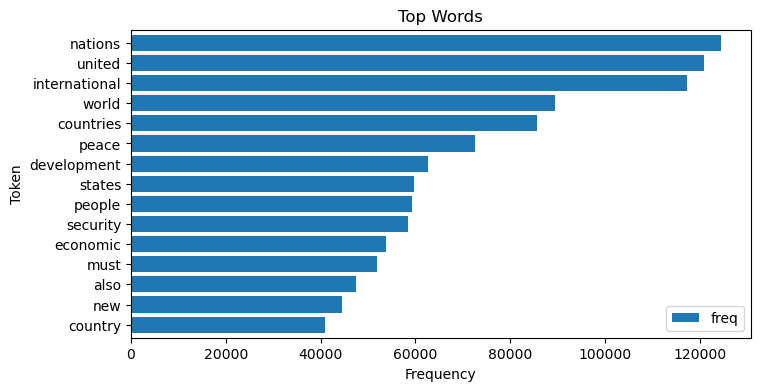

In [34]:
ax = freq_df.head(15).plot(kind='barh', width=0.8, figsize=(8,4))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

##### <b>Word Cloud</b>

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]
text

'Seventy years after the founding of the United Nations it is worth reflecting on what the members of this body, working together, have helped to achieve. Out of the ashes of the Second World War, having witnessed the unthinkable power of the atomic age, the United States has worked with many nations in the Assembly to prevent a third world war — by forging alliances with old adversaries; by supporting the steady emergence of strong democracies accountable to their people and not to any foreign Power; and by building an international system that imposes a cost on those who choose conflict over cooperation, an order that recognizes the dignity and equal worth of all people.\nThat has been the work of seven decades. That is the ideal that this body has, at its best, pursued. Of course, there have been too many times when, collectively, we have fallen short of those ideals. Over the seven decades, terrible conflicts have claimed untold victims. But we have pressed forward, slowly, steadil

(-0.5, 399.5, 199.5, -0.5)

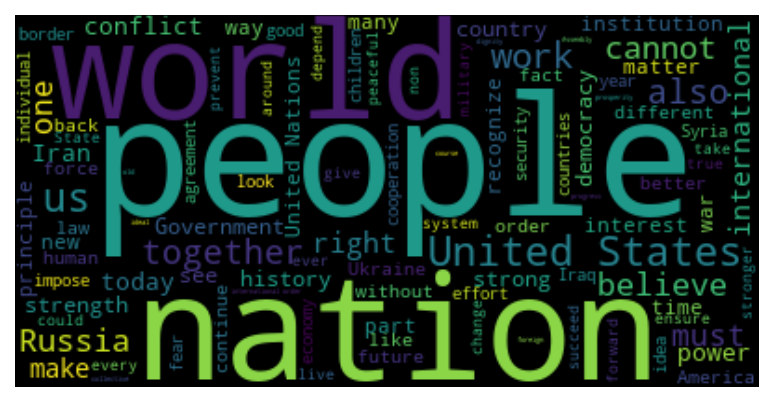

In [36]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

##### <b>Keyword-in-Context Function</b>

In [37]:
from textacy.extract.kwic import keyword_in_context
import random

def kwic(doc_series, keyword, window=35, print_samples=5):
    
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' + \
                  sample[1] + ' ' + re.sub(r'[\n\t]', ' '. sample[2]))

In [38]:
kwic(df[df['year']==2005]['text'], 'sdgs', print_samples=5)

0 random samples out of 0 contexts for 'sdgs':


##### <b>N-Gram</b>

In [39]:
def ngram(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = 'the visible manifestation of the global climate change'
tokens = tokenize(text)
print(tokens)

print("|".join(ngram(tokens,2)))

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']
the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [40]:
# N-Gram with stopwords removal

def ngram(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

text = 'the visible manifestation of the global climate change'
tokens = tokenize(text)
print(tokens)

print("|".join(ngram(tokens,2,stopwords=stopwords)))

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']
visible manifestation|global climate|climate change


##### <b>Creating frequency timelines</b>

In [41]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0 ) for k in keywords]

In [42]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'terrorism', 'climate', 'freedom', 'climate', 'freedom']

In [43]:
print(count_keywords(tokens=tokens, keywords=keywords))

[1, 1, 2, 2]


In [44]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]

    return freq_df.groupby(by).sum().sort_values(by)

In [45]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.head(10)

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


<AxesSubplot:xlabel='year'>

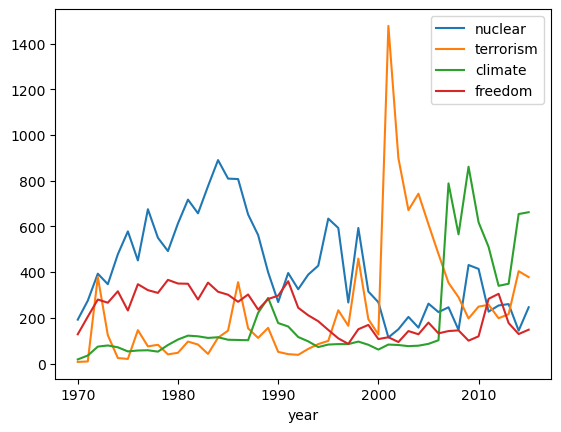

In [46]:
freq_df.plot(kind='line')

##### <b>Homework</b>

##### <b>Find the top 10 word bigram from US General Debates of year 1970-1990 and compare with those of years 1990-the lastest (remove stopwords first)</b>

In [47]:
# 1970-1990
year70_90 = df.query("year >= 1970 and year <= 1990")

# pass ngram function
year70_90['ngrams'] = year70_90['tokens'].apply(lambda tokens: ngram(tokens, n=2, sep=' ', stopwords=set()))

from collections import Counter

# Step 1: Flatten the list of bigrams
all_bigrams = [bigram for ngram_list in year70_90['ngrams'] for bigram in ngram_list]

# Step 2: Count the occurrences of each bigram
bigram_counts = Counter(all_bigrams)

# Step 3: Sort the bigrams by count in descending order
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Select the top 10 bigrams
top_10_bigrams = sorted_bigrams[:10]

# Print the top 10 bigrams
for bigram, count in top_10_bigrams:
    print(f'Bigram: "{bigram}", Count: {count}')

C:\Users\samapant\AppData\Local\Temp\ipykernel_3664\1944353335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year70_90['ngrams'] = year70_90['tokens'].apply(lambda tokens: ngram(tokens, n=2, sep=' ', stopwords=set()))


Bigram: "united nations", Count: 43846
Bigram: "general assembly", Count: 13915
Bigram: "developing countries", Count: 11991
Bigram: "international community", Count: 11506
Bigram: "south africa", Count: 9300
Bigram: "united states", Count: 7718
Bigram: "middle east", Count: 7608
Bigram: "security council", Count: 7500
Bigram: "peace security", Count: 6755
Bigram: "human rights", Count: 6569


In [48]:
# 1990-2015
year90_15 = df.query("year >= 1990")

# pass ngram function
year90_15['ngrams'] = year90_15['tokens'].apply(lambda tokens: ngram(tokens, n=2, sep=' ', stopwords=set()))

from collections import Counter

# Step 1: Flatten the list of bigrams
all_bigrams = [bigram for ngram_list in year90_15['ngrams'] for bigram in ngram_list]

# Step 2: Count the occurrences of each bigram
bigram_counts = Counter(all_bigrams)

# Step 3: Sort the bigrams by count in descending order
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Select the top 10 bigrams
top_10_bigrams = sorted_bigrams[:10]

# Print the top 10 bigrams
for bigram, count in top_10_bigrams:
    print(f'Bigram: "{bigram}", Count: {count}')

C:\Users\samapant\AppData\Local\Temp\ipykernel_3664\2463745160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year90_15['ngrams'] = year90_15['tokens'].apply(lambda tokens: ngram(tokens, n=2, sep=' ', stopwords=set()))


Bigram: "united nations", Count: 61529
Bigram: "international community", Count: 16924
Bigram: "security council", Count: 14040
Bigram: "general assembly", Count: 13694
Bigram: "human rights", Count: 13658
Bigram: "peace security", Count: 8704
Bigram: "developing countries", Count: 7027
Bigram: "member states", Count: 6037
Bigram: "sustainable development", Count: 5281
Bigram: "climate change", Count: 5159


##### <b>Create a bigram word cloud of the US General Debates dataset of years 1970 and 1990 to the lastest (remove stopwords first)</b>

In [49]:
df['ngrams'] = df['tokens'].apply(lambda tokens: ngram(tokens, n=2, sep=' ', stopwords=set()))

In [50]:
text_1970_1990 = df.query("year >= 1970 and year <= 1990")['ngrams'].values

ngrams_1970_1990 = []

for ngram_list in text_1970_1990:
    ngrams_1970_1990.extend(ngram_list)

ngrams_1970_1990_text = ' '.join(ngrams_1970_1990)

(-0.5, 399.5, 199.5, -0.5)

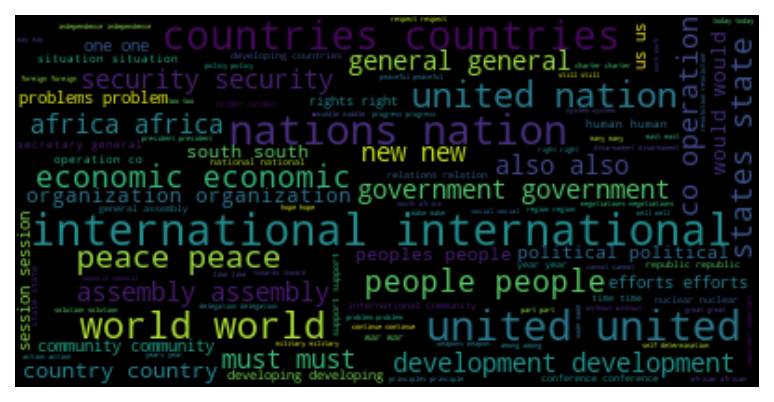

In [51]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(ngrams_1970_1990_text)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [52]:
text_1990_present = df.query("year >= 1990")['ngrams'].values

ngrams_1990_2015 = []

for ngram_list in text_1990_present:
    ngrams_1990_2015.extend(ngram_list)

ngrams_1990_2015_text = ' '.join(ngrams_1990_2015)

(-0.5, 399.5, 199.5, -0.5)

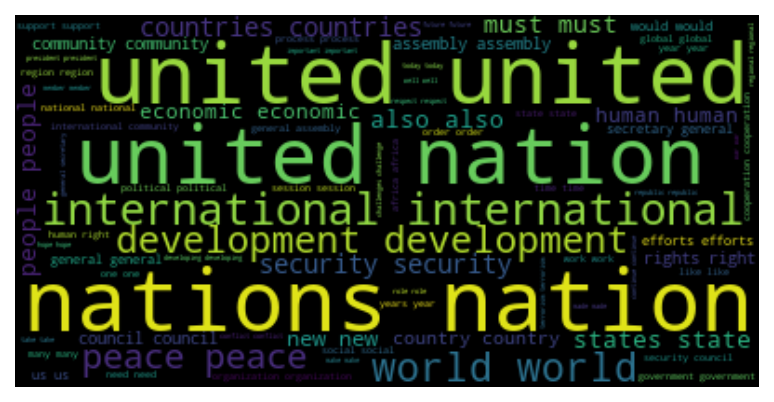

In [53]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(ngrams_1990_2015_text)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

##### <b>Create a trend graph showing the bigram and word trend of "climate change", "global warming", "wars", and 3 others of your choices</b>

<AxesSubplot:xlabel='year'>

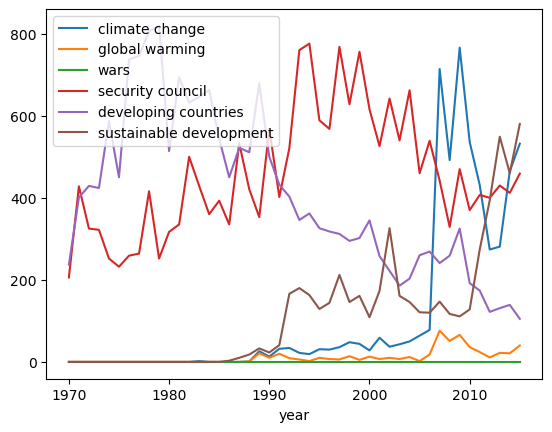

In [54]:
keywords = ['climate change', 'global warming', 'wars',
            'security council', 'developing countries', 'sustainable development']
# keywords = ['indeed pleasure']
word_trend = count_keywords_by(df, by='year', keywords=keywords, column='ngrams')
word_trend.plot(kind='line') 